<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/summer-program/week1/Linear_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Autoencoder (Linear Autoencoder)



We'll start off by building a simple autoencoder to compress the FossilNET dataset.

Autoencoders are neural networks that learn to compress data by passing it through two stages: an encoder and a decoder. The encoder takes the input data and compresses it into a lower-dimensional representation. The decoder then takes this representation and reconstructs the original input data.

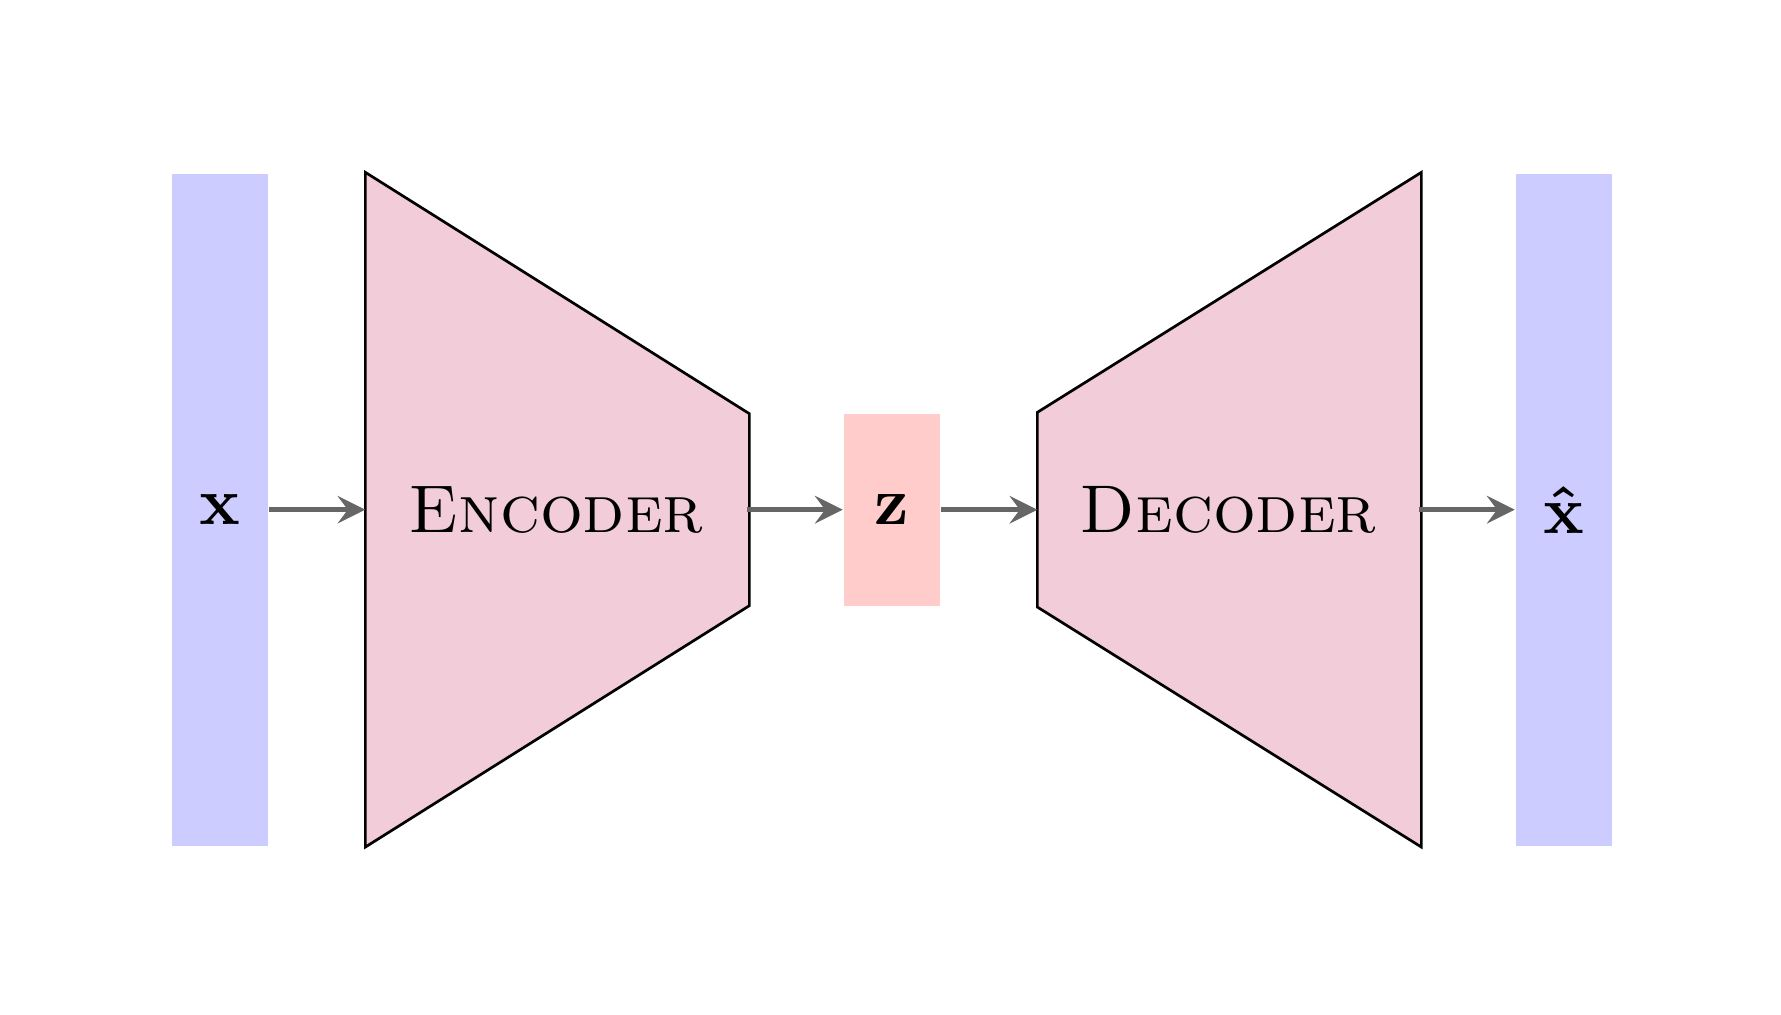
<p align = "center">
Fig.1 - Autoencoder Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

We will try to visualize the generative power of autoencoders in this tutorial by generating new samples based on input images. Some other use cases of autoencoders include the following:
 - Image Denoising (the input is noisy image and output is denoised image)
 - Image completion (the input is an image with a patch missing and the output is completed image)
 - Data encoding and dimenensionality reduction.

In [ ]:
# Load fossil data (the file dataloader_fossilnet.py)
from google.colab import files
src = list(files.upload().values())[0]
open('dataloader_fossilnet.py','wb').write(src)

Saving dataloader_fossilnet.py to dataloader_fossilnet.py


3570

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from dataloader_fossilnet import FossilNET

In [3]:
#Model-Hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-4
BATCH_SIZE = 64
Z = 256

In [4]:
# We will be using the Fossil dataset

transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples {len(training_data)}')

# Randomly select a small subset of samples
# training_data = torch.utils.data.Subset(training_data, np.random.choice(len(training_data), 600, replace=False))

Downloading...


100%|██████████| 192646640/192646640 [00:06<00:00, 29748166.67it/s]


Extracting dataset/FossilNET.zip to dataset
Done!
Training samples 2000


In [5]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

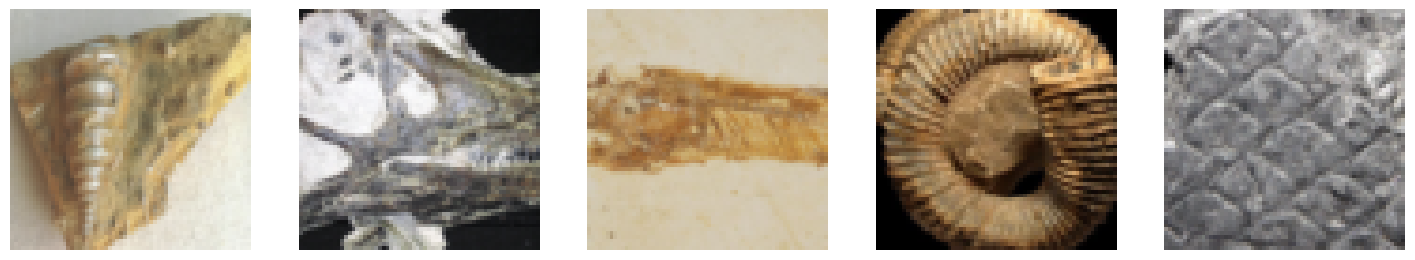

In [6]:
# Visualizing some sample images
figure = plt.figure(figsize=(18, 14))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), interpolation='none')
plt.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We'll train an autoencoder with these images by flattening them into 64 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of one linear layer. The units that connect the encoder and decoder will be the compressed representation.

Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

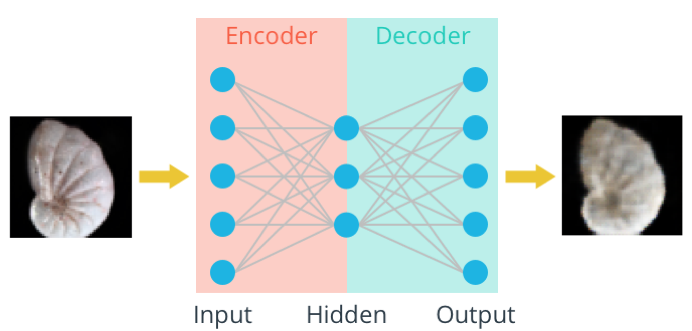

In [8]:
import torch.nn.functional as F
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (64 -> encoding_dim)
        self.fc1 = nn.Linear(8 * 8, encoding_dim)

        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 8 * 8)


    def forward(self, x):
        print(x.shape)
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
model = model.to(device)
print(model)

Autoencoder(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
)


Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

In [9]:
# Defining the optimizer and loss function here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [ ]:
# Training loop
loss_history = []
for i in range(1,EPOCHS+1):
    running_loss = 0
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Every data instance is an input + label pair. We don't need the label
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
    loss_history.append(running_loss)

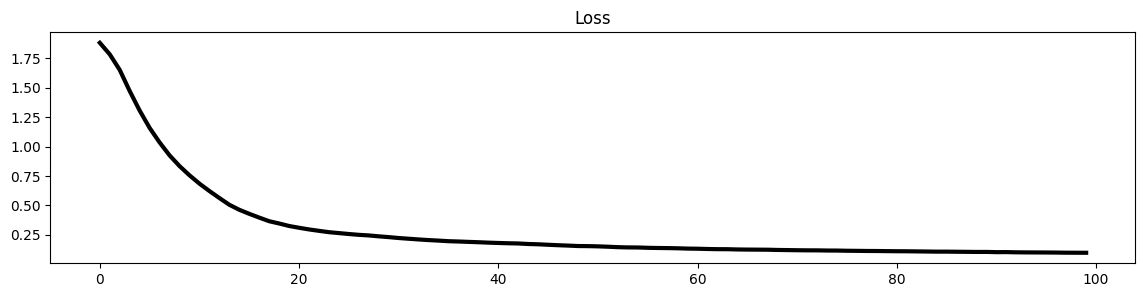

In [11]:
# Visualizing the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [12]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [13]:
# Set the model to eval state
model.eval()

Autoencoder(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
)

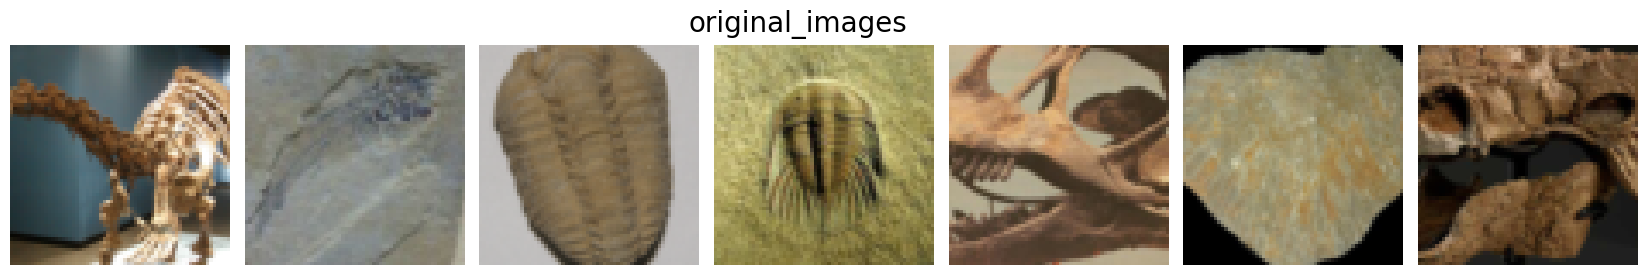

torch.Size([7, 3, 64, 64])


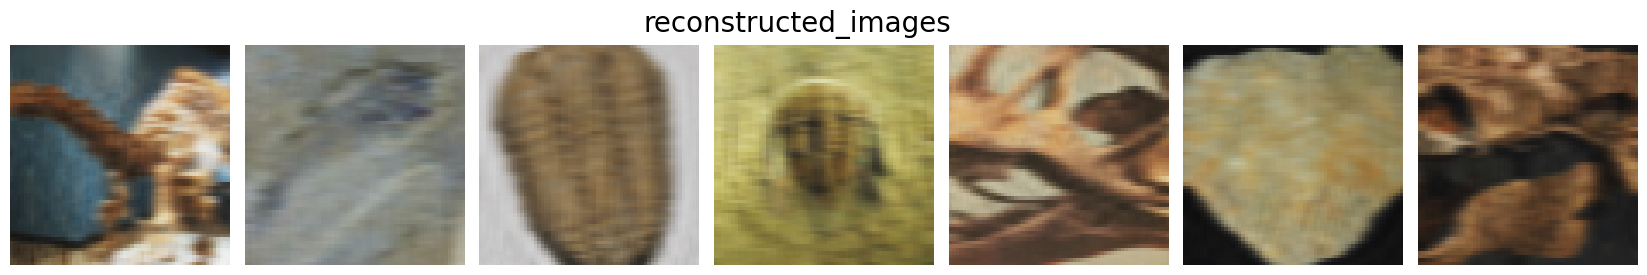

In [14]:
# Display some sample images and there reconstruction through auto encoders

images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")
with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device)).cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")


# What's next ..
As we're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.